# Comparing Machine Learning Models for Stock Market Price Prediction

**CS 5805: Machine Learning Final Project**

Pranesh Ambokar, Mohammad Heydari, Roshan Ravindran, and Leo St. Amour

## Overview

This project analyzes and compares the performance characteristics and prediction accuracy trade-offs of linear regression and long short-term memory (LSTM) when applied to stock market prediction. We train the models using historical stock data and ask them to predict a stock's closing price given its opening, low, and high prices.

## Environmental Setup

This project depends on several `python` machine learning and data science libraries:
- `pandas`: a powerful library for manipulating data in a `DataFrame` object.
- `numpy`: a library for aiding scientific computing.
- `matplotlib`: a library for plotting graphs.
- `scikit-learn`: a machine learning library that implements linear regression.
- `tensorflow`: a machine learning library that provides an LSTM implementation.
- `keras_tuner`: a library that aids in hyper-parameter fine-tuning.

To install the dependencies, run the following command:

```
$ python3 -m pip install numpy pandas matplotlib scikit-learn tensorflow keras_tuner
```

In [1]:
# General libraries
import glob
import os
import time

# Scientific computing and data manipulation
import pandas as pd
import numpy as np

# Graphing
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Linear regression
from sklearn.linear_model import LinearRegression

# LSTM
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
tf.get_logger().setLevel('ERROR')

## Fine-tune LSTM hyper-parameters
import keras_tuner as kt

## Only retrain the LSTM model if explicitly instructed; otherwise, load a saved model
from tensorflow.keras.saving import load_model
retrain_lstm = False

# Prices will be scaled to improve model efficiency
from sklearn.preprocessing import MinMaxScaler

# Accuracy metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

If you want to force re-train the LSTM model, uncomment and run the following cell. If not, the saved model will be loaded.

In [2]:
# retrain_lstm = True

## Data and Preprocessing

### Data

Our data set consists of historical price data for 100 stocks, 50 of which are large-cap and 50 of which are mid-cap. The data for each stock is stored as a CSV file containing the following columns: `Date`, `Open`, `High`, `Low`, `Close`, `Adj Close`, and `Volume`. For our experiments, we used the `Open`, `High`, and `Low` columns as input features and the `Close` column as the output. We create our overall data set by aggregating each stock's historical data into a single data frame.

After aggregating the data, the data points are sorted by date. This step is important because the training data for the LSTM model **must** maintain its time-series integrity.

In [3]:
# Define paths for the directories
mid_cap_path = './mid_cap'
large_cap_path = './large_cap'

# Load files from both directories
all_files = glob.glob(os.path.join(mid_cap_path, '*_data.csv')) + glob.glob(os.path.join(large_cap_path, '*_data.csv'))

df_list = []

for csv in all_files:
    df = pd.read_csv(csv)
    df['Stock'] = os.path.basename(csv).split('_')[0]  # Extract stock ticker from filename
    df_list.append(df)
data = pd.concat(df_list, ignore_index=True)
data = data.sort_values(['Stock', 'Date'])

### Training, Validation, and Testing Sets

We split our data set into training, validation, and testing sets using a 70/15/15 ratio. To accomplish this, the first 70% of dates for each stock are added to a testing set, the next 15% for each stock is added to a validation set, and the final 15% is added to a testing set.

After the training, validation, and testing sets have been established, they are split into input (`Open`, `Low`, and `High`) and output (`Close`) components.

In [4]:
# Create training/validation/testing sets using a 70/15/15 split
training_data = []
validation_data = []
testing_data = []

for stock in data['Stock'].unique():
    stock_data = data[data['Stock'] == stock]
    train_size = int(len(stock_data) * 0.7)
    val_size = int(len(stock_data) * 0.15)
    
    # Split the data for each stock
    training_data.append(stock_data.iloc[:train_size])
    validation_data.append(stock_data.iloc[train_size:train_size+val_size])
    testing_data.append(stock_data.iloc[train_size+val_size:])

# Concatenate the split data
training_data = pd.concat(training_data, ignore_index=True)
validation_data = pd.concat(validation_data, ignore_index=True)
testing_data = pd.concat(testing_data, ignore_index=True)

# Define the features (Open, Low, High) and target (Close)
training_X = training_data[['Open', 'Low', 'High']]
training_Y = training_data[['Close']]
validation_X = validation_data[['Open', 'Low', 'High']]
validation_Y = validation_data[['Close']]
testing_X = testing_data[['Open', 'Low', 'High']]
testing_Y = testing_data[['Close']]

# Check the number of features in the training data
num_features = training_X.shape[1]

# Output the split data for verification
print(f"Training data: {len(training_data)} rows")
print(f"Validation data: {len(validation_data)} rows")
print(f"Testing data: {len(testing_data)} rows")

Training data: 571741 rows
Validation data: 122477 rows
Testing data: 122631 rows


To improve the training efficiency of LSTM, we scale all prices to a value between zero and one.

In [5]:
# Scale the data
scaler_X = MinMaxScaler(feature_range=(0, 1))  # For the features
scaler_Y = MinMaxScaler(feature_range=(0, 1))  # For the target (Close)

# Scale the features and target for training and testing sets
training_X_scaled = scaler_X.fit_transform(training_X)
testing_X_scaled = scaler_X.transform(testing_X)
validation_X_scaled = scaler_X.transform(validation_X)

# Scale the target variable (Close) for training and testing sets
training_Y_scaled = scaler_Y.fit_transform(training_Y)
testing_Y_scaled = scaler_Y.transform(testing_Y)
validation_Y_scaled = scaler_Y.transform(validation_Y)

The input to an LSTM model is different than a linear regression. Instead of an array of input data points, it accepts an array of sequences. This required us to transform the inputs and outputs of each data set. We have selected 60, meaning that the algorithm will look back for 60 days when training.

In [6]:
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        target_value = data[i + sequence_length]
        sequences.append(seq)
        targets.append(target_value)
    
    return np.array(sequences), np.array(targets)

sequence_length = 60
training_X_scaled_lstm, training_Y_scaled_lstm = create_sequences(training_X_scaled, sequence_length)
validation_X_scaled_lstm, validation_Y_scaled_lstm = create_sequences(validation_X_scaled, sequence_length)
testing_X_scaled_lstm, testing_Y_scaled_lstm = create_sequences(testing_X_scaled, sequence_length)

## Training and Validation

### Linear Regression

In [7]:
%%time
linear_regression_model = LinearRegression()
linear_regression_model.fit(training_X_scaled, training_Y_scaled)

CPU times: user 61.9 ms, sys: 182 µs, total: 62.1 ms
Wall time: 59.8 ms


LinearRegression()

We are interested in reporting the correlation between the input and output as well as the trained coefficients.

In [8]:
# Calculate correlation of features
correlation = training_data[['Open', 'Low', 'High', 'Close']].corr()['Close'].drop('Close')

# Retrieve regression coefficients from the trained linear regression model
coefficients = linear_regression_model.coef_.flatten()

feature_selection_table = pd.DataFrame({
    'Feature': ['Open', 'Low', 'High'],
    'Correlation with Close': correlation.values,
    'Regression Coefficient': coefficients
})

print(feature_selection_table)

  Feature  Correlation with Close  Regression Coefficient
0    Open                0.999881               -0.375897
1     Low                0.999956                0.661434
2    High                0.999959                0.711065


### LSTM

#### Hyper-parameter Tuning

The LSTM model has a number of hyper-parameters that can be tuned to find an optimal model. We have selected:
- Units in the LSTM layer
- LSTM recurrent dropout rate
- Droput layer rate
- Learning rate

Others that we kept static, but could be further explored are:
- The size of training sequences
- The number of training epochs
- Larger ranges for selected hyper-parameters

We selected the number of parameters and their ranges to identify optimal values in a feasible amount of computational time. Using the values below, fine-tuning took approximately a day and a half.

In [9]:
def build_model(hp):
    model = Sequential([
        Input(shape=(training_X_scaled_lstm.shape[1], training_X_scaled_lstm.shape[2])),
        LSTM(units=hp.Choice('units', [50, 100, 150]),
             recurrent_dropout=hp.Choice('recurrent_dropout', [0.1, 0.2]),
             return_sequences=False),
        Dropout(hp.Choice('dropout', [0.2, 0.3])),
        Dense(units=1)
    ])
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.0005, 0.001, 0.005])), loss='mean_squared_error')
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    directory='kt_dir',
    project_name='lstm_tuning_simple'
)

tuner.search(
    training_X_scaled_lstm, training_Y_scaled_lstm,
    epochs=5,  # Fewer epochs for faster evaluation
    validation_data=(validation_X_scaled_lstm, validation_Y_scaled_lstm),
    batch_size=32
)

best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Hyperparameters: {best_hyperparameters.values}")

Reloading Tuner from kt_dir/lstm_tuning_simple/tuner0.json
Best Hyperparameters: {'units': 150, 'recurrent_dropout': 0.1, 'dropout': 0.3, 'learning_rate': 0.005}


After identifying the optimum hyper-parameter values, use them to train the model.

If the `retrain_lstm` variable is set to `True`, the model will be re-trained. If the variable is `False`, then the model will be loaded from disk.

NOTE: When the model was trained for the first time, the training time was approximately 1 hour and 17 minutes. This data is lost when the following cell loads the model instead of re-training it.

In [10]:
%%time
if retrain_lstm:
    lstm_model = tuner.hypermodel.build(best_hyperparameters)
    history = lstm_model.fit(
        training_X_scaled_lstm, training_Y_scaled_lstm,
        validation_data=(validation_X_scaled_lstm, validation_Y_scaled_lstm),
        epochs=10,  
        batch_size=32
    )
    lstm_model.save('lstm_trained.keras')
else:
    lstm_model = load_model("lstm_trained.keras")

CPU times: user 124 ms, sys: 8.32 ms, total: 132 ms
Wall time: 128 ms


## Testing

We evaluate our models by testing them against each stock in the testing data set. When we test the models, first, we collect the following metrics:
- Mean squared error (MSE)
- Mean absolute error (MAE)
- R$^2$ value

Second, we capture the range of dates comprising the training and testing sets and the time it takes to make a prediction. These metrics are saved in a `DataFrame` for subsequent analysis. Finally, for each test, we generate and save a graph that compares the predicted closing prices to the actual closing prices.

In [11]:
%%time
metrics = pd.DataFrame(columns=[
    'Stock', 'Model', 
    'Train Start', 'Train End', 
    'Test Start', 'Test End', 
    'MSE', 'MAE', 'R2', 
    'Time to Predict'
])

def new_metric(stock_symbol, model):
    stock_training_data = training_data[training_data['Stock'] == stock_symbol]
    stock_testing_data = testing_data[testing_data['Stock'] == stock_symbol]

    stock_data = testing_data[testing_data['Stock'] == stock_symbol]
    stock_X = stock_data[['Open', 'Low', 'High']]
    stock_Y = stock_data[['Close']]
    
    # Scale test data
    stock_X_scaled = scaler_X.transform(stock_X)
    stock_Y_scaled = scaler_Y.transform(stock_Y)
    
    if model == 'LSTM':
        stock_X_scaled_lstm, _ = create_sequences(stock_X_scaled, sequence_length)
        start = time.time()
        predictions_scaled = lstm_model.predict(stock_X_scaled_lstm, verbose=0)
        prediction_time = time.time() - start
        predictions = scaler_Y.inverse_transform(predictions_scaled)
        actual_values = scaler_Y.inverse_transform(stock_Y_scaled[sequence_length:])
        stock_Y_scaled = stock_Y_scaled[sequence_length:]
    else:
        start = time.time()
        predictions_scaled = linear_regression_model.predict(stock_X_scaled)
        prediction_time = time.time() - start
        predictions = scaler_Y.inverse_transform(predictions_scaled)
        actual_values = stock_Y_scaled
        
    mse = mean_squared_error(stock_Y_scaled, predictions_scaled)
    mae = mean_absolute_error(stock_Y_scaled, predictions_scaled)
    r2 = r2_score(stock_Y_scaled, predictions_scaled)

    # Plot actual vs predicted prices for visualization
    plt.plot(actual_values, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.xlabel('Days')
    plt.ylabel('Dollars ($)')
    plt.legend()
    plt.title(f'{model}: {stock_symbol} - Actual vs Predicted Prices')
    plt.savefig(f'graphs/{stock_symbol}-{model}.png', bbox_inches='tight')
    plt.clf()
    
    return {
        'Stock': stock_symbol,
        'Model': model,
        'Train Start': stock_training_data['Date'].iloc[0],
        'Train End': stock_training_data['Date'].iloc[-1],
        'Test Start': stock_testing_data['Date'].iloc[0],
        'Test End': stock_testing_data['Date'].iloc[-1],
        'MSE': mse,
        'MAE': mae,
        'R2': r2,
        'Time to Predict': prediction_time
    }

for stock in data['Stock'].unique():
    metrics = metrics._append(new_metric(stock, 'LSTM'), ignore_index=True)
    metrics = metrics._append(new_metric(stock, 'LR'), ignore_index=True)
metrics

CPU times: user 1min 49s, sys: 4.46 s, total: 1min 53s
Wall time: 1min 26s


Stock Model                Train Start                  Train End  \
0    005930.KS  LSTM  2000-01-04 00:00:00+09:00  2017-04-05 00:00:00+09:00   
1    005930.KS    LR  2000-01-04 00:00:00+09:00  2017-04-05 00:00:00+09:00   
2      2222.SR  LSTM  2019-12-11 00:00:00+03:00  2023-05-30 00:00:00+03:00   
3      2222.SR    LR  2019-12-11 00:00:00+03:00  2023-05-30 00:00:00+03:00   
4    600519.SS  LSTM  2001-08-27 00:00:00+08:00  2017-10-25 00:00:00+08:00   
..         ...   ...                        ...                        ...   
195       YELP    LR  2012-03-02 00:00:00-05:00  2021-02-01 00:00:00-05:00   
196       ZBRA  LSTM  1991-08-15 00:00:00-04:00  2014-11-26 00:00:00-05:00   
197       ZBRA    LR  1991-08-15 00:00:00-04:00  2014-11-26 00:00:00-05:00   
198       ZION  LSTM  1980-03-17 00:00:00-05:00  2011-06-20 00:00:00-04:00   
199       ZION    LR  1980-03-17 00:00:00-05:00  2011-06-20 00:00:00-04:00   

                    Test Start                   Test End           MSE  \
0    2021-02-02 00:00:00+09:00  2024-11-26 00:00:00+09:00  1.718051e+00   
1    2021-02-02 00:00:00+09:00  2024-11-26 00:00:00+09:00  1.047147e-04   
2    2024-02-25 00:00:00+03:00  2024-11-26 00:00:00+03:00  1.187878e-08   
3    2024-02-25 00:00:00+03:00  2024-11-26 00:00:00+03:00  2.122870e-09   
4    2021-05-13 00:00:00+08:00  2024-11-26 00:00:00+08:00  1.529482e-06   
..                         ...                        ...           ...   
195  2022-12-28 00:00:00-05:00  2024-11-26 00:00:00-05:00  2.142295e-09   
196  2019-11-26 00:00:00-05:00  2024-11-26 00:00:00-05:00  1.390780e-07   
197  2019-11-26 00:00:00-05:00  2024-11-26 00:00:00-05:00  9.542538e-09   
198  2018-03-09 00:00:00-05:00  2024-11-26 00:00:00-05:00  9.190022e-09   
199  2018-03-09 00:00:00-05:00  2024-11-26 00:00:00-05:00  2.245474e-09   

          MAE         R2  Time to Predict  
0    1.291654 -33.005300         0.488517  
1    0.008220   0.997984         0.000118  
2    0.000109 -57.573413         0.079754  
3    0.000046  -0.743424         0.000096  
4    0.000965   0.887262         0.229779  
..        ...        ...              ...  
195  0.000046   0.907104         0.000104  
196  0.000298   0.985866         0.332057  
197  0.000076   0.999018         0.000114  
198  0.000090   0.875841         0.422137  
199  0.000046   0.968677         0.000114  

[200 rows x 10 columns]

<Figure size 432x288 with 0 Axes>

In [12]:
print(metrics[metrics['Model'] == 'LSTM'].describe())
print(metrics[metrics['Model'] == 'LR'].describe())

                MSE         MAE          R2  Time to Predict
count  1.000000e+02  100.000000  100.000000       100.000000
mean   1.718054e-02    0.013026   -0.061432         0.377172
std    1.718051e-01    0.129154    6.753361         0.199697
min    1.073158e-09    0.000023  -57.573413         0.079754
25%    5.778439e-09    0.000063    0.912855         0.229182
50%    9.238444e-09    0.000082    0.977283         0.373332
75%    2.111002e-08    0.000122    0.990870         0.486358
max    1.718051e+00    1.291654    0.998832         1.319289
                MSE         MAE          R2  Time to Predict
count  1.000000e+02  100.000000  100.000000       100.000000
mean   1.061115e-06    0.000157    0.956476         0.000129
std    1.047012e-05    0.000818    0.176965         0.000027
min    2.210366e-10    0.000011   -0.743424         0.000096
25%    2.241096e-09    0.000046    0.970335         0.000112
50%    3.086958e-09    0.000048    0.988275         0.000120
75%    7.109775e-09    0

Some stocks include a negative R$^2$ value, which does not make sense mathematically. This is likely due to vastly different mean values between training and testing sets. See this [stack overflow post](https://stackoverflow.com/questions/23036866/scikit-learn-is-returning-coefficient-of-determination-r2-values-less-than-1) for more details. We decided to drop any stocks for which either model resulted in a negative R$^2$ value.

In [13]:
stocks_to_keep = metrics.groupby('Stock')['R2'].transform(lambda x: x.min() >= 0)
stocks_with_negative_r2 = metrics.groupby('Stock')['R2'].transform(lambda x: x.min() < 0)

cleaned_metrics = metrics[stocks_to_keep]
unusual_metrics = metrics[stocks_with_negative_r2]

After removing the rows with negative R$^2$ values, we get metrics (mean, min, max, etc.) that make much more sense.

In [14]:
print(cleaned_metrics[cleaned_metrics['Model'] == 'LSTM'].describe())
print(cleaned_metrics[cleaned_metrics['Model'] == 'LR'].describe())

                MSE        MAE         R2  Time to Predict
count  9.600000e+01  96.000000  96.000000        96.000000
mean   3.894118e-08   0.000110   0.935895         0.383501
std    1.589024e-07   0.000111   0.112403         0.198662
min    1.073158e-09   0.000023   0.290762         0.081351
25%    5.634920e-09   0.000063   0.937110         0.253904
50%    9.142392e-09   0.000080   0.978954         0.378560
75%    2.111002e-08   0.000121   0.991427         0.488424
max    1.529482e-06   0.000965   0.998832         1.319289
                MSE        MAE         R2  Time to Predict
count  9.600000e+01  96.000000  96.000000        96.000000
mean   1.448265e-08   0.000076   0.977783         0.000129
std    3.523183e-08   0.000073   0.027252         0.000027
min    2.210366e-10   0.000011   0.881954         0.000097
25%    2.259764e-09   0.000046   0.971851         0.000112
50%    3.170435e-09   0.000048   0.988644         0.000121
75%    7.109775e-09   0.000068   0.997126         0.0001

We removed four stocks from the data set. These stocks can be further investigated to understand why they produced unusual R$^2$ values.

In [15]:
unusual_metrics

Stock Model                Train Start                  Train End  \
0    005930.KS  LSTM  2000-01-04 00:00:00+09:00  2017-04-05 00:00:00+09:00   
1    005930.KS    LR  2000-01-04 00:00:00+09:00  2017-04-05 00:00:00+09:00   
2      2222.SR  LSTM  2019-12-11 00:00:00+03:00  2023-05-30 00:00:00+03:00   
3      2222.SR    LR  2019-12-11 00:00:00+03:00  2023-05-30 00:00:00+03:00   
64         HBI  LSTM  2006-09-06 00:00:00-04:00  2019-06-10 00:00:00-04:00   
65         HBI    LR  2006-09-06 00:00:00-04:00  2019-06-10 00:00:00-04:00   
176        VVV  LSTM  2016-09-23 00:00:00-04:00  2022-06-13 00:00:00-04:00   
177        VVV    LR  2016-09-23 00:00:00-04:00  2022-06-13 00:00:00-04:00   

                    Test Start                   Test End           MSE  \
0    2021-02-02 00:00:00+09:00  2024-11-26 00:00:00+09:00  1.718051e+00   
1    2021-02-02 00:00:00+09:00  2024-11-26 00:00:00+09:00  1.047147e-04   
2    2024-02-25 00:00:00+03:00  2024-11-26 00:00:00+03:00  1.187878e-08   
3    2024-02-25 00:00:00+03:00  2024-11-26 00:00:00+03:00  2.122870e-09   
64   2022-03-03 00:00:00-05:00  2024-11-26 00:00:00-05:00  1.852838e-08   
65   2022-03-03 00:00:00-05:00  2024-11-26 00:00:00-05:00  2.147926e-09   
176  2023-09-06 00:00:00-04:00  2024-11-26 00:00:00-05:00  8.558006e-09   
177  2023-09-06 00:00:00-04:00  2024-11-26 00:00:00-05:00  2.161890e-09   

          MAE         R2  Time to Predict  
0    1.291654 -33.005300         0.488517  
1    0.008220   0.997984         0.000118  
2    0.000109 -57.573413         0.079754  
3    0.000046  -0.743424         0.000096  
64   0.000136  -5.112241         0.217333  
65   0.000046   0.663123         0.000151  
176  0.000090  -0.298146         0.115523  
177  0.000046   0.862790         0.000112

### Accuracy Graphs

The R$^2$ values demonstrated by our metrics suggest that both models perform well at predicting closing prices. To better visualize the accuracies of the models, we output side-by-side graphs depicting the difference between the actual and predicted closing prices for each model and stock.

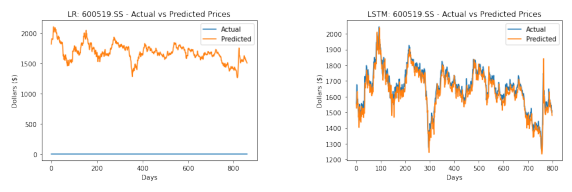

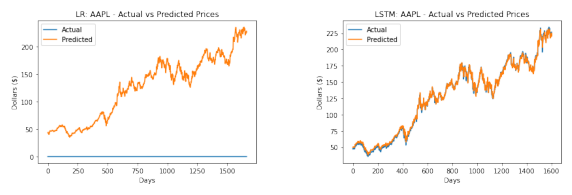

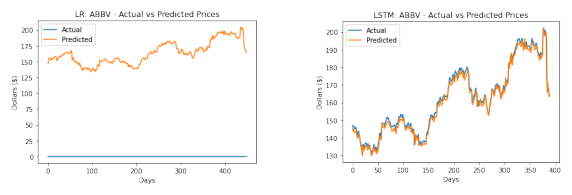

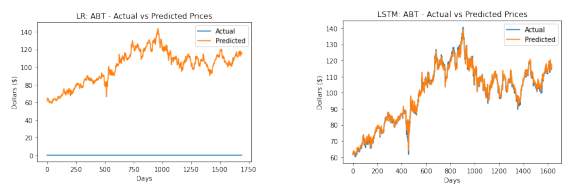

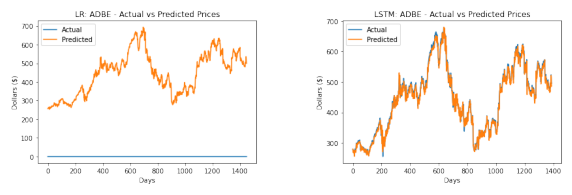

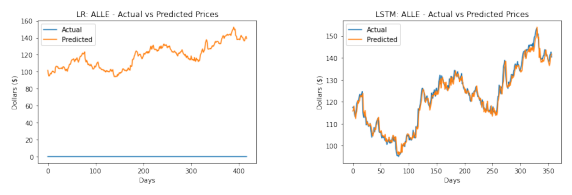

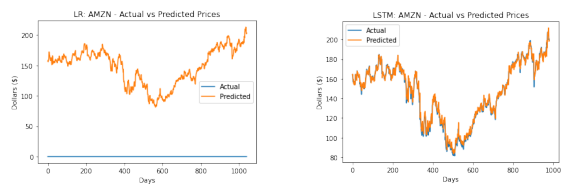

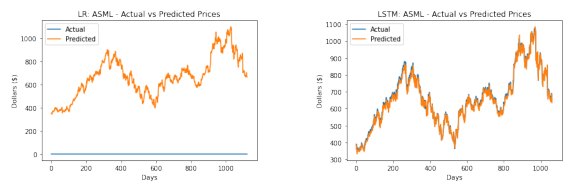

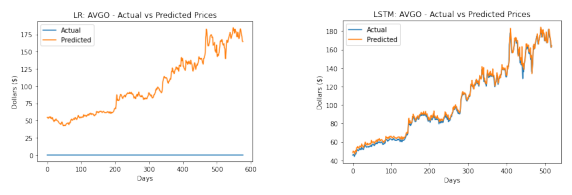

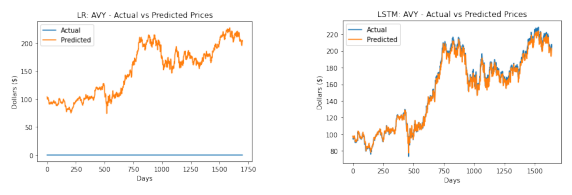

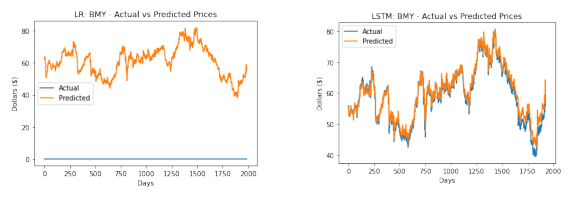

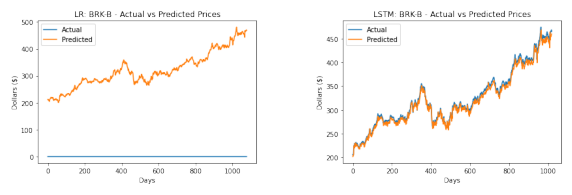

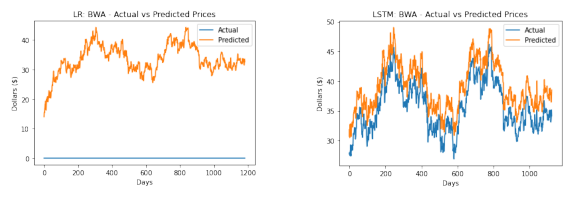

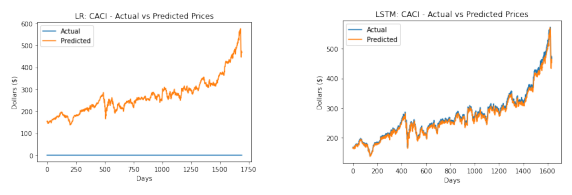

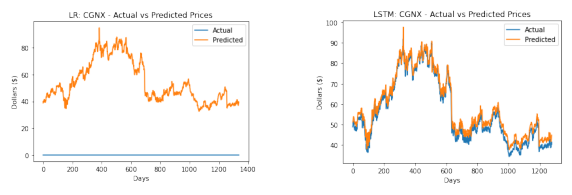

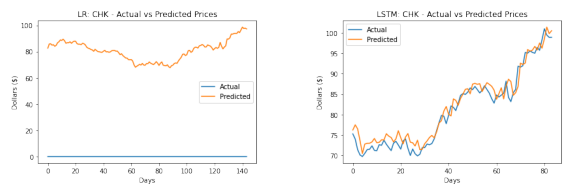

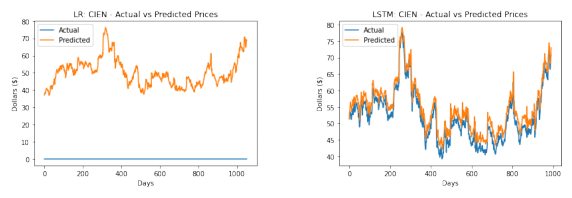

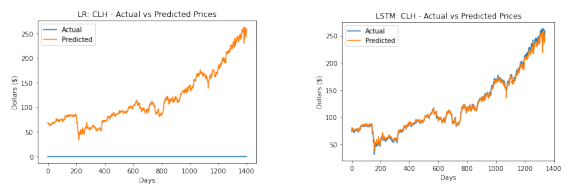

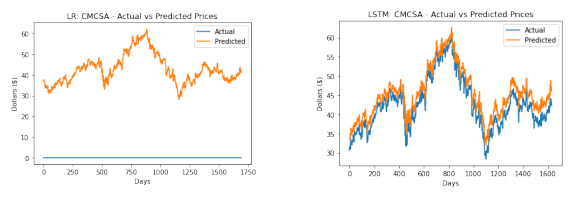

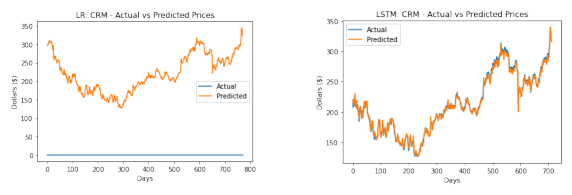

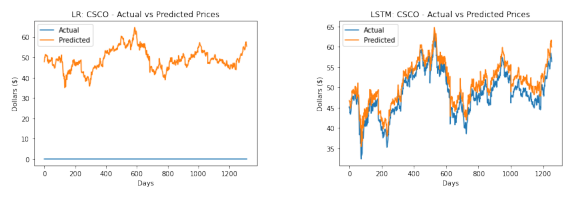

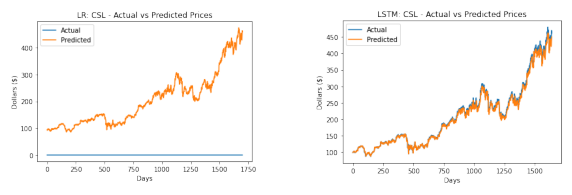

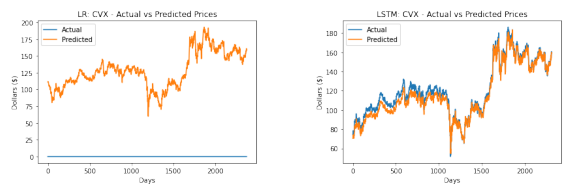

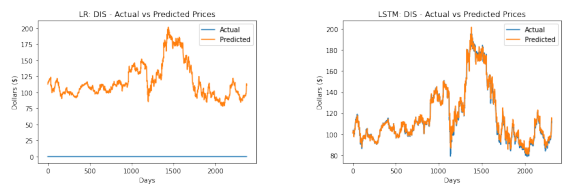

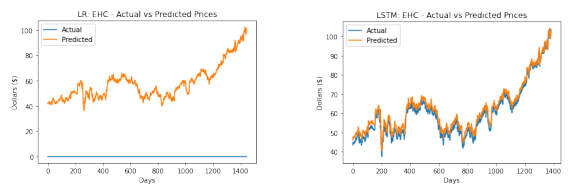

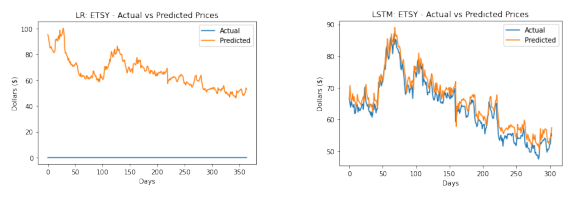

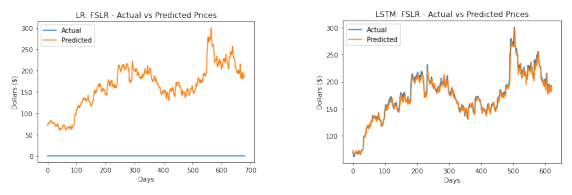

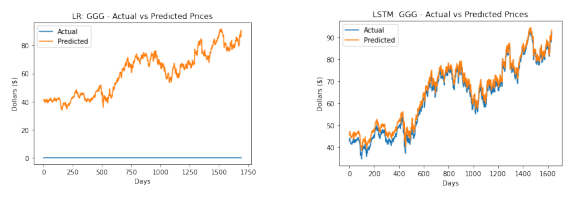

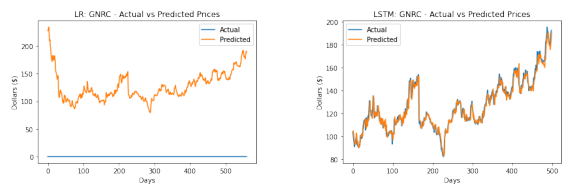

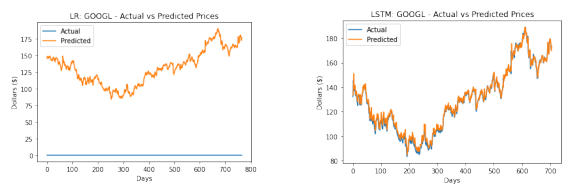

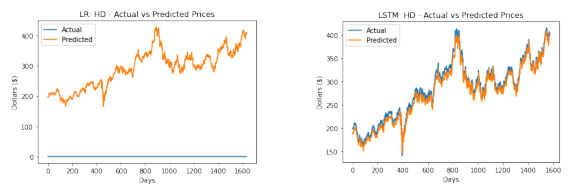

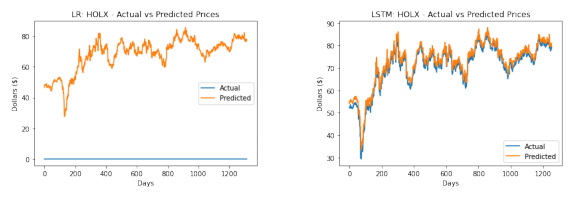

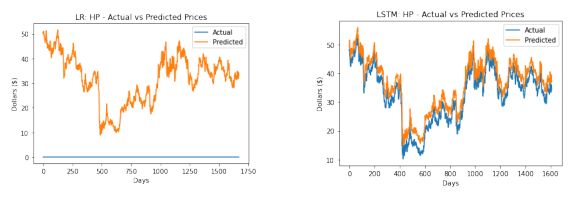

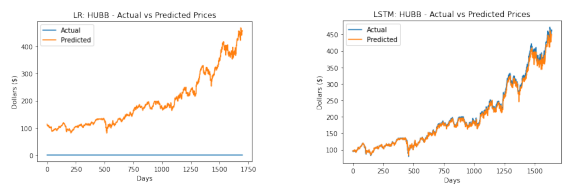

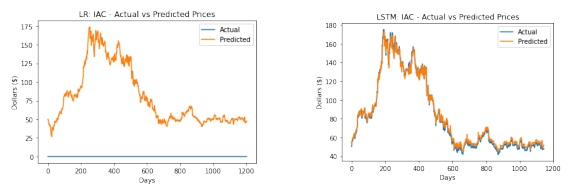

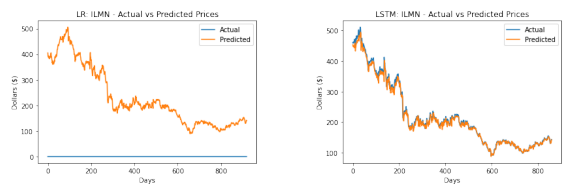

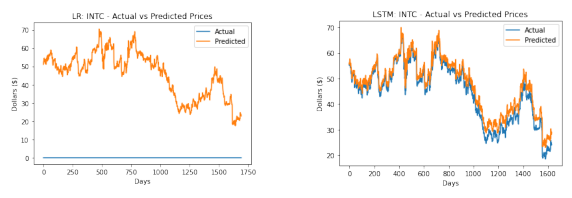

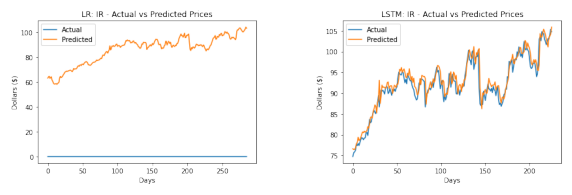

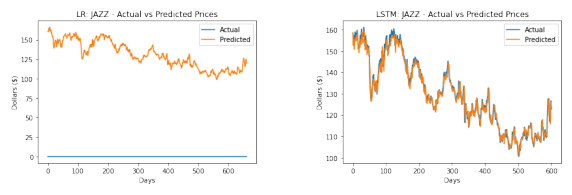

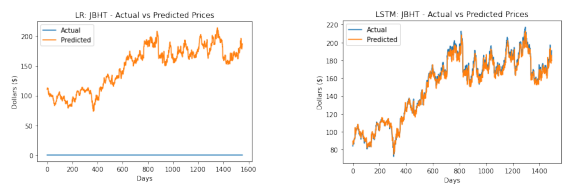

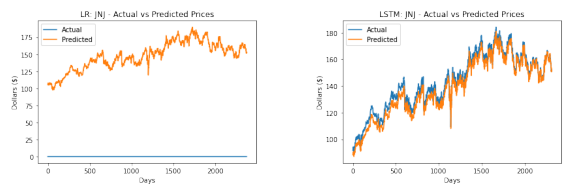

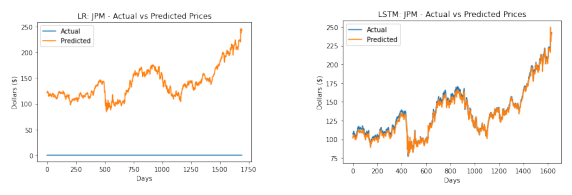

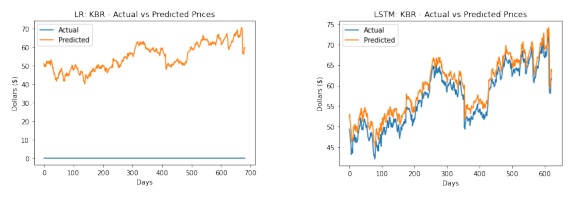

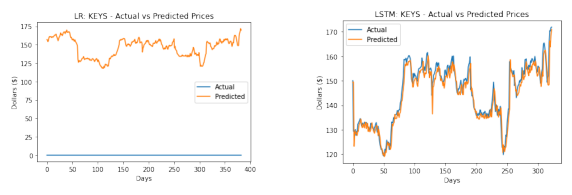

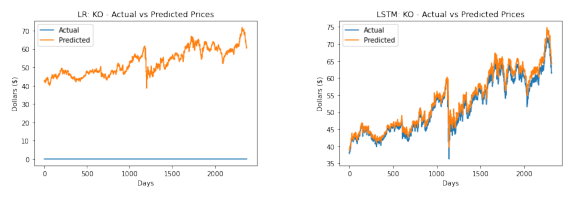

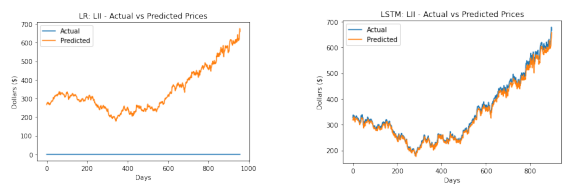

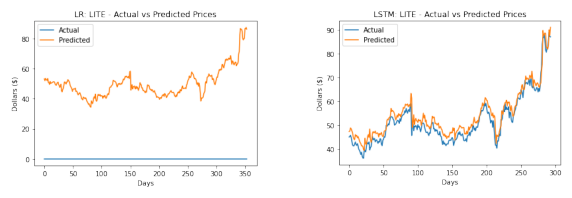

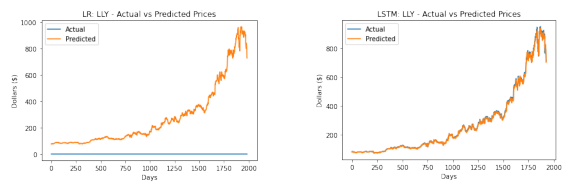

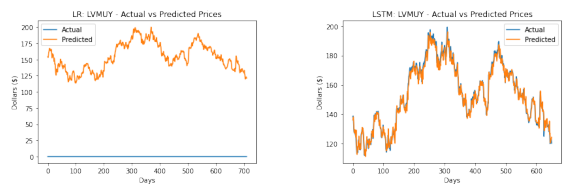

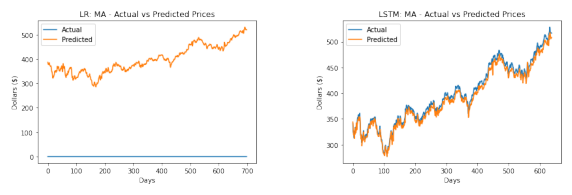

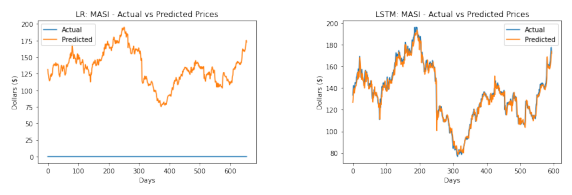

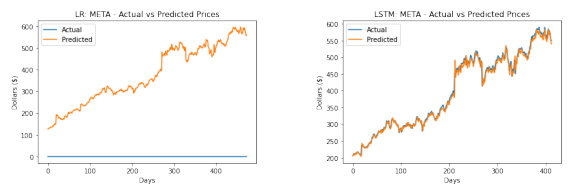

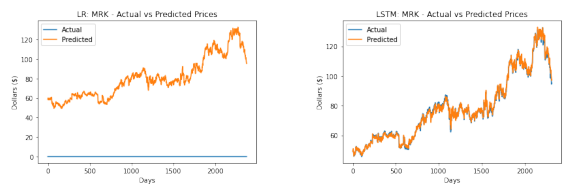

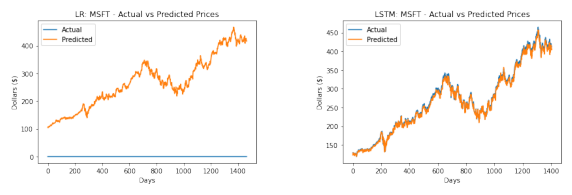

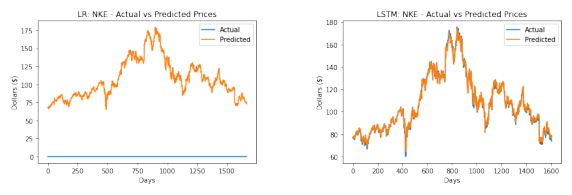

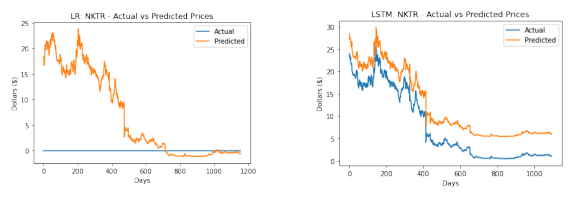

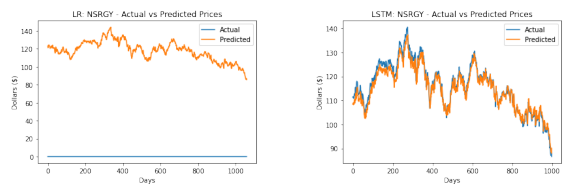

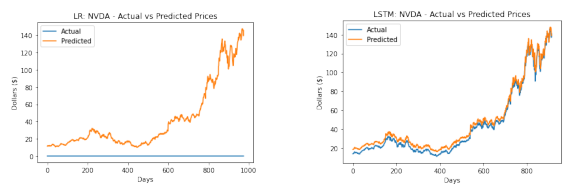

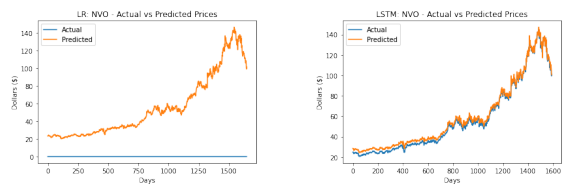

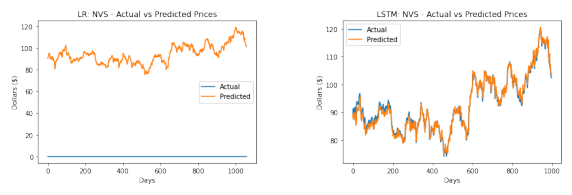

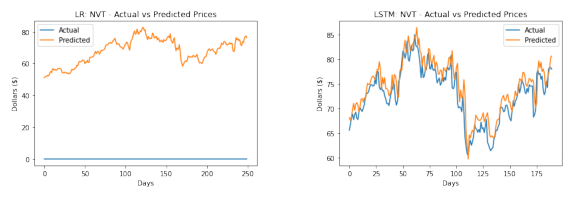

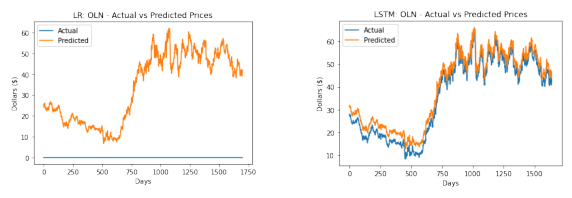

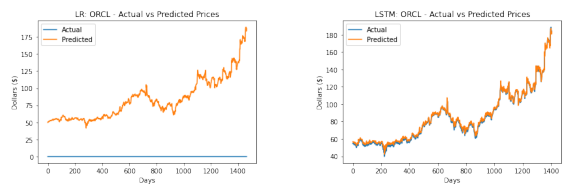

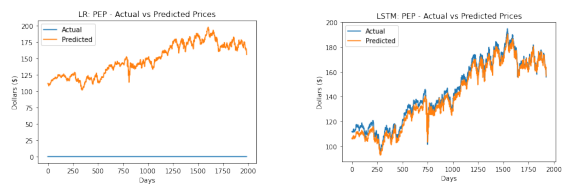

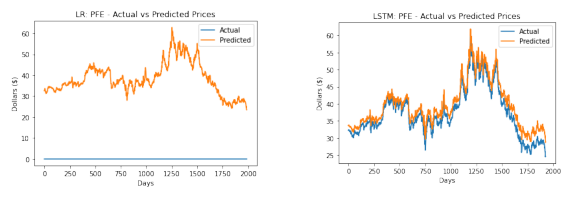

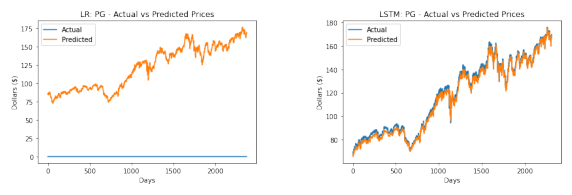

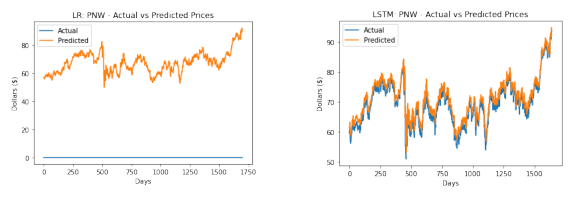

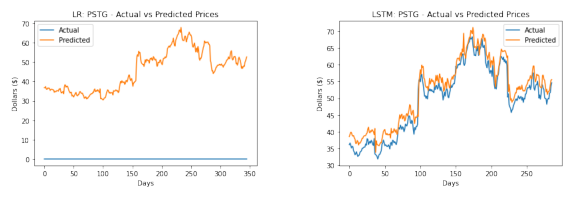

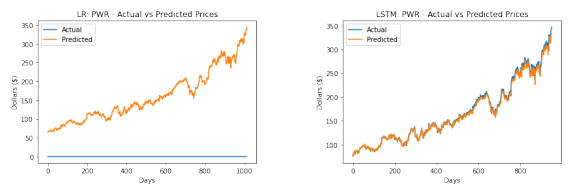

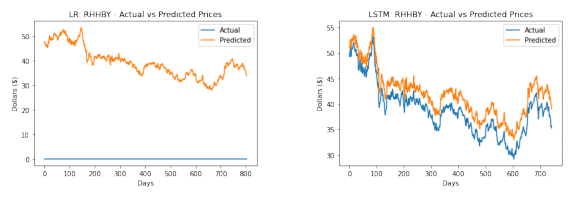

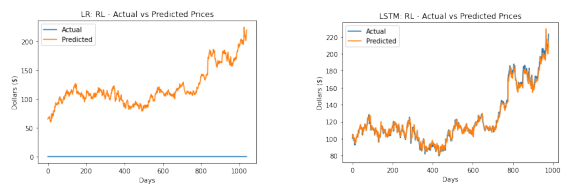

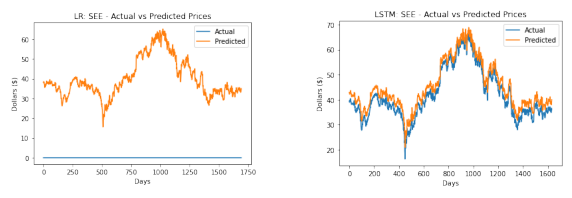

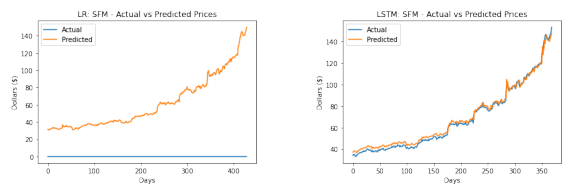

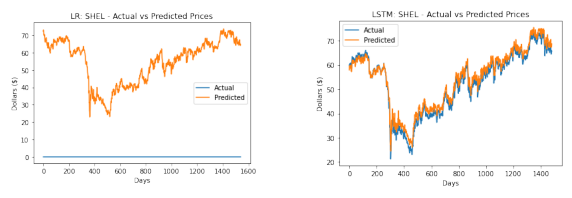

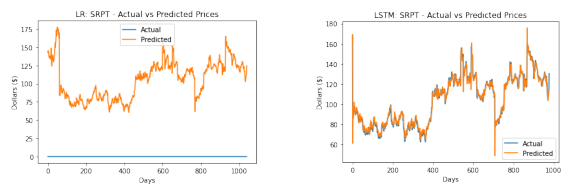

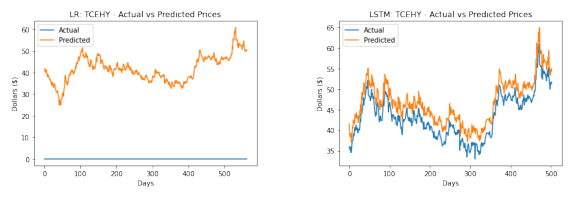

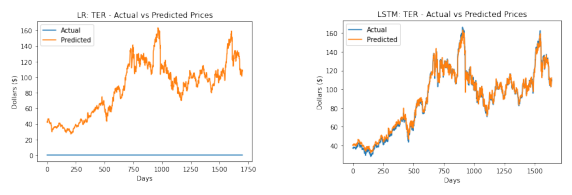

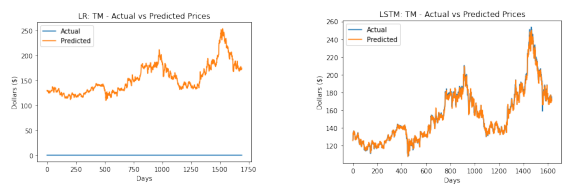

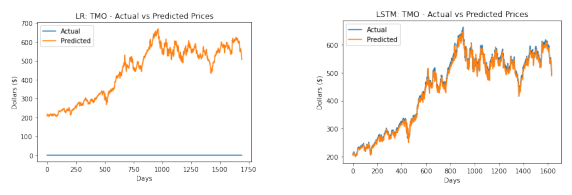

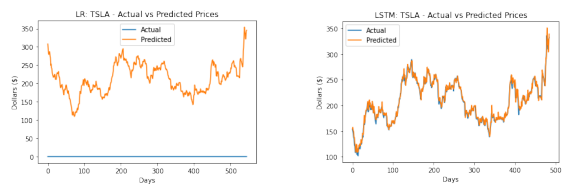

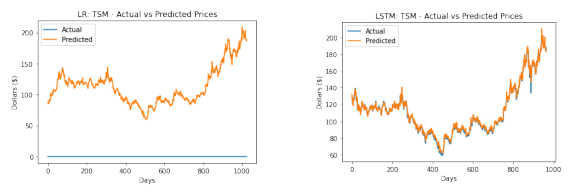

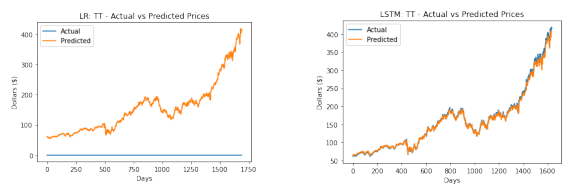

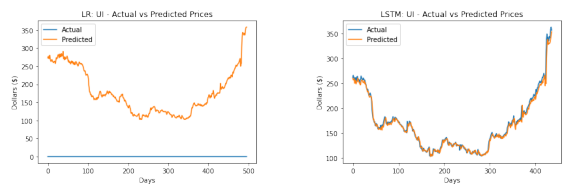

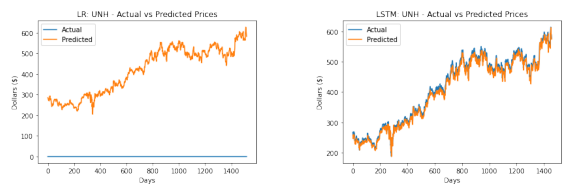

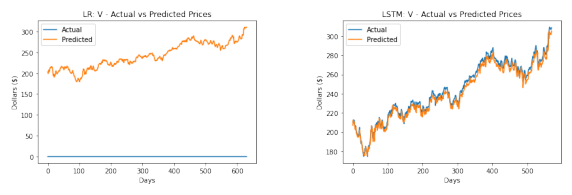

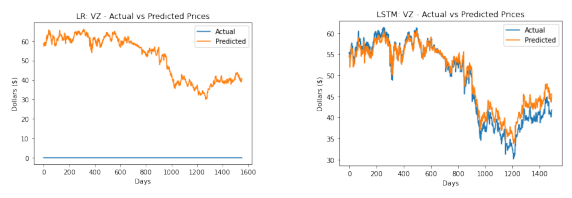

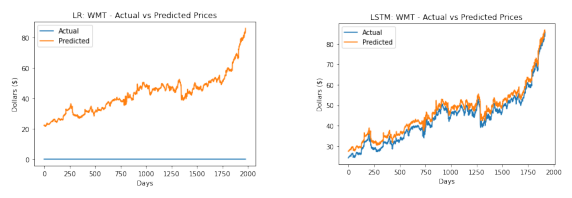

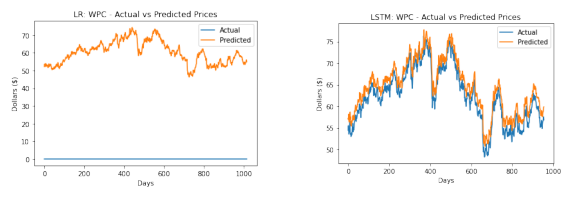

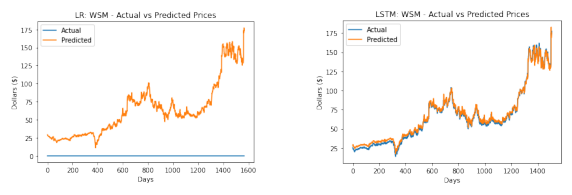

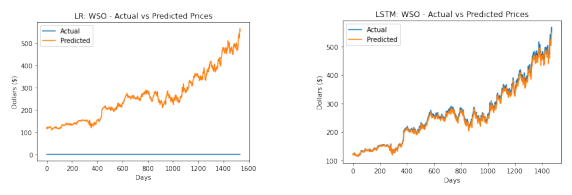

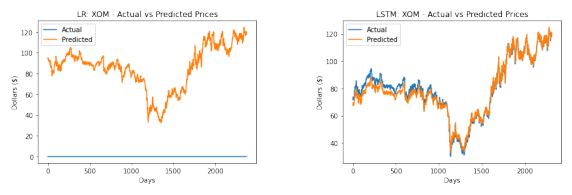

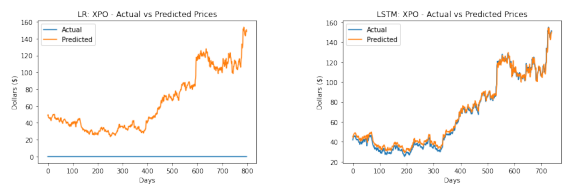

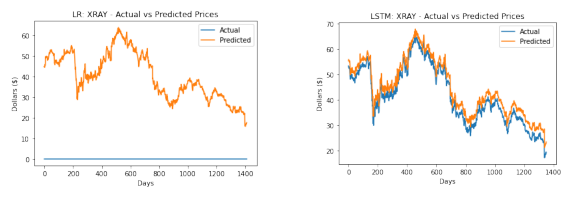

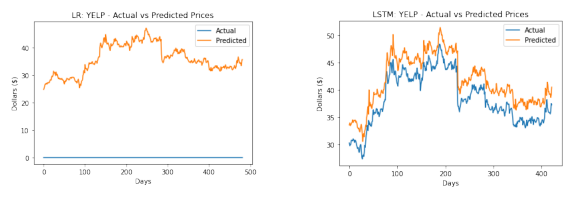

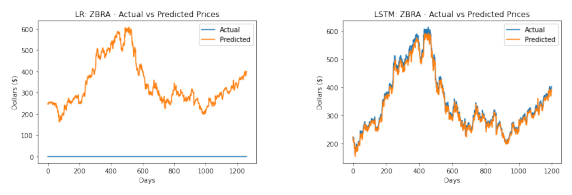

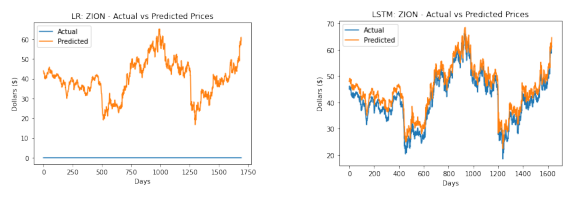

In [16]:
def show_graphs(stock_symbol):
    image1 = mpimg.imread(f'graphs/{stock_symbol}-LR.png')
    image2 = mpimg.imread(f'graphs/{stock_symbol}-LSTM.png')

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Display image 1
    axs[0].imshow(image1)
    axs[0].axis('off')

    # Display image 2
    axs[1].imshow(image2)
    axs[1].axis('off')

    # Show the plot
    plt.show()

for stock in cleaned_metrics['Stock'].unique():
    show_graphs(stock)

Notice that for the unusual stocks, we see a greater margin of error for (in most cases) both models. 

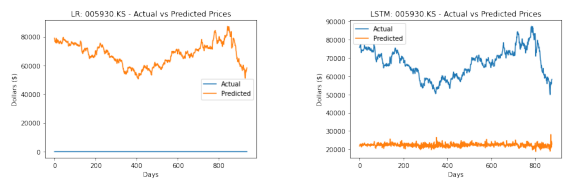

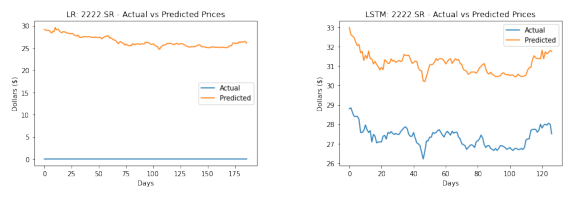

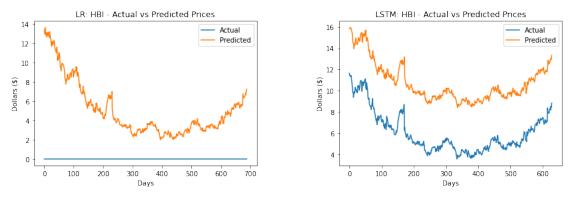

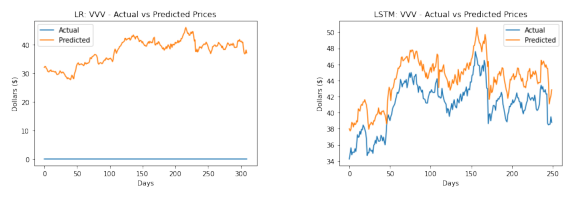

In [17]:
for stock in unusual_metrics['Stock'].unique():
    show_graphs(stock)

### Day Trading Simulation

To better quantify the real-world impact of each model, we implement a simulation to evaluate the model's ability to make day trading predictions. Specifically, we randomly select several stocks and predict which of those stocks would produce the highest yield on the last day of data (i.e., the greatest difference between the closing and opening price). We then compare the prediction to the stock that produced the greatest yield. We select two stocks and calculate the accuracy based on 100 trials. We repeat this process, incrementing the number of stocks chosen by one until we reach 30.

In [18]:
def day_trading_simulation(model, model_type, n_trials=100, max_stocks=30):
    # Test different numbers of stocks
    stock_accuracies = {i: [] for i in range(2, max_stocks + 1)}
 
    for num_stocks in range(2, max_stocks + 1):
        for _ in range(n_trials):
            stocks = np.random.choice(cleaned_metrics['Stock'].unique(), num_stocks)
            diffs = {}
            for stock in stocks:
                test_rows = testing_data[testing_data['Stock'] == stock].tail(1) # Predict for last day
                test_open = test_rows['Open']
                test_close = test_rows['Close']
                
                actual_diffs = test_close - test_open
                
                stock_X = test_rows[['Open', 'Low', 'High']]
                stock_Y = test_rows[['Close']]
                stock_X_scaled = scaler_X.transform(stock_X)
                stock_Y_scaled = scaler_Y.transform(stock_Y)

                if model_type == 'LSTM':
                    stock_X_scaled = np.array([stock_X_scaled])
                    predictions_scaled = model.predict(stock_X_scaled, verbose=False)
                else:
                    predictions_scaled = model.predict(stock_X_scaled)
                predictions = scaler_Y.inverse_transform(predictions_scaled)
                predicted_diffs = predictions[0] - test_open
                diffs[stock] = (predicted_diffs, actual_diffs)
 
            best_stock_diff_predicted = 0
            best_stock_predicted = ''
            best_stock_diff_actual = 0
            best_stock_actual = ''
            for stock in stocks:
                predicted = diffs[stock][0].iloc[0]  # Just look at first day
                if predicted > best_stock_diff_predicted:
                    best_stock_diff_predicted = predicted
                    best_stock_predicted = stock
                actual = diffs[stock][1].iloc[0]  # Just look at first day
                if actual > best_stock_diff_actual:
                    best_stock_diff_actual = actual
                    best_stock_actual = stock
            accuracy = 1.0 if best_stock_actual == best_stock_predicted else 0.0
            stock_accuracies[num_stocks].append(accuracy)
     
    # Create plot
    plt.figure(figsize=(12, 7))
     
    # Plot mean accuracy for each number of stocks with confidence intervals
    means = [np.mean(stock_accuracies[n]) for n in range(2, max_stocks + 1)]
    stds = [np.std(stock_accuracies[n]) for n in range(2, max_stocks + 1)]
    conf_intervals = [1.96 * std / np.sqrt(n_trials) for std in stds]  # 95% confidence intervals
     
    plt.plot(range(2, max_stocks + 1), means, 'o-', color='skyblue', linewidth=2, markersize=8)
    plt.fill_between(range(2, max_stocks + 1), 
                     [m - ci for m, ci in zip(means, conf_intervals)],
                     [m + ci for m, ci in zip(means, conf_intervals)],
                     color='skyblue', alpha=0.3)
 
    # Add random baseline
    random_baseline = [1/n for n in range(2, max_stocks + 1)]
    plt.plot(range(2, max_stocks + 1), random_baseline, 'r--', alpha=0.5, label='Random Guess (1/n)')
     
    plt.title('Prediction Accuracy vs Number of Stocks (1-day prediction)', fontsize=14, pad=15)
    plt.xlabel('Number of Stocks', fontsize=12)
    plt.ylabel('Average Accuracy', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
     
    # Add mean accuracy values on top of points
    for i, mean in enumerate(means):
        plt.text(i+2, mean, f'{mean:.3f}', ha='center', va='bottom')
     
    plt.tight_layout()
    plt.savefig(f'graphs/day-trading-simulation-{model_type}.png', bbox_inches='tight')
    plt.show()
    #plt.clf()
     
    # Print summary statistics
    print("\nSummary for each number of stocks:")
    for num_stocks in range(2, max_stocks + 1):
        print(f"\n{num_stocks} stocks:")
        print(f"Mean accuracy: {np.mean(stock_accuracies[num_stocks]):.3f}")
        print(f"Random guess: {1/num_stocks:.3f}")
        print(f"Std dev: {np.std(stock_accuracies[num_stocks]):.3f}")
        print(f"95% CI: ({np.mean(stock_accuracies[num_stocks]) - 1.96*np.std(stock_accuracies[num_stocks])/np.sqrt(n_trials):.3f}, "
              f"{np.mean(stock_accuracies[num_stocks]) + 1.96*np.std(stock_accuracies[num_stocks])/np.sqrt(n_trials):.3f})")

We conduct the day trading simulation with each model and output the results for comparison.

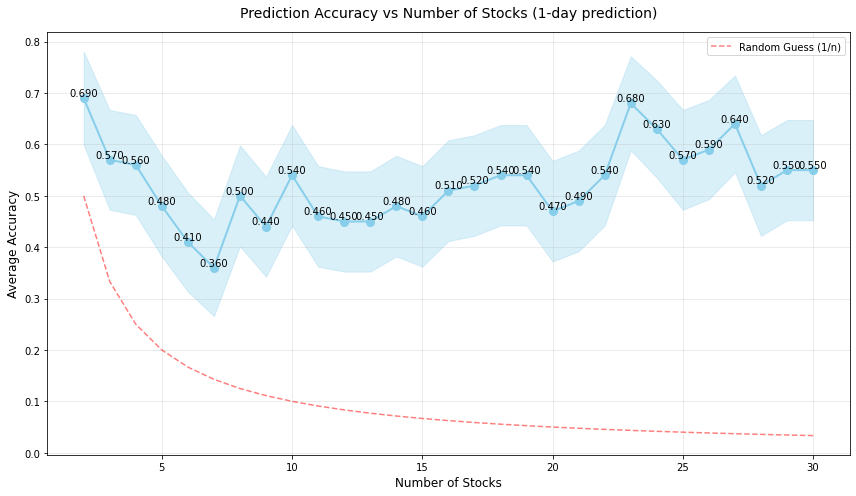


Summary for each number of stocks:

2 stocks:
Mean accuracy: 0.690
Random guess: 0.500
Std dev: 0.462
95% CI: (0.599, 0.781)

3 stocks:
Mean accuracy: 0.570
Random guess: 0.333
Std dev: 0.495
95% CI: (0.473, 0.667)

4 stocks:
Mean accuracy: 0.560
Random guess: 0.250
Std dev: 0.496
95% CI: (0.463, 0.657)

5 stocks:
Mean accuracy: 0.480
Random guess: 0.200
Std dev: 0.500
95% CI: (0.382, 0.578)

6 stocks:
Mean accuracy: 0.410
Random guess: 0.167
Std dev: 0.492
95% CI: (0.314, 0.506)

7 stocks:
Mean accuracy: 0.360
Random guess: 0.143
Std dev: 0.480
95% CI: (0.266, 0.454)

8 stocks:
Mean accuracy: 0.500
Random guess: 0.125
Std dev: 0.500
95% CI: (0.402, 0.598)

9 stocks:
Mean accuracy: 0.440
Random guess: 0.111
Std dev: 0.496
95% CI: (0.343, 0.537)

10 stocks:
Mean accuracy: 0.540
Random guess: 0.100
Std dev: 0.498
95% CI: (0.442, 0.638)

11 stocks:
Mean accuracy: 0.460
Random guess: 0.091
Std dev: 0.498
95% CI: (0.362, 0.558)

12 stocks:
Mean accuracy: 0.450
Random guess: 0.083
Std dev: 

In [19]:
%%time
day_trading_simulation(linear_regression_model, 'LR')

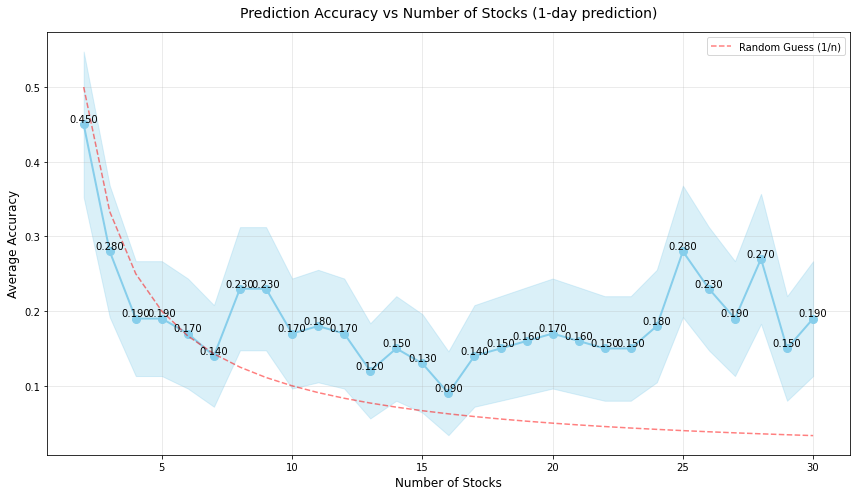


Summary for each number of stocks:

2 stocks:
Mean accuracy: 0.450
Random guess: 0.500
Std dev: 0.497
95% CI: (0.352, 0.548)

3 stocks:
Mean accuracy: 0.280
Random guess: 0.333
Std dev: 0.449
95% CI: (0.192, 0.368)

4 stocks:
Mean accuracy: 0.190
Random guess: 0.250
Std dev: 0.392
95% CI: (0.113, 0.267)

5 stocks:
Mean accuracy: 0.190
Random guess: 0.200
Std dev: 0.392
95% CI: (0.113, 0.267)

6 stocks:
Mean accuracy: 0.170
Random guess: 0.167
Std dev: 0.376
95% CI: (0.096, 0.244)

7 stocks:
Mean accuracy: 0.140
Random guess: 0.143
Std dev: 0.347
95% CI: (0.072, 0.208)

8 stocks:
Mean accuracy: 0.230
Random guess: 0.125
Std dev: 0.421
95% CI: (0.148, 0.312)

9 stocks:
Mean accuracy: 0.230
Random guess: 0.111
Std dev: 0.421
95% CI: (0.148, 0.312)

10 stocks:
Mean accuracy: 0.170
Random guess: 0.100
Std dev: 0.376
95% CI: (0.096, 0.244)

11 stocks:
Mean accuracy: 0.180
Random guess: 0.091
Std dev: 0.384
95% CI: (0.105, 0.255)

12 stocks:
Mean accuracy: 0.170
Random guess: 0.083
Std dev: 

In [20]:
%%time
day_trading_simulation(lstm_model, 'LSTM')

## References

- https://pieriantraining.com/tensorflow-lstm-example-a-beginners-guide. This reference was instrumental in helping us understand how to use the `tensorflow` library. Specifically, we leveraged this tutorial's `create_sequences` function to appropriately pre-process the input data.
- We utilized ChatGPT to help write helper functions for graphing the results and ingesting/aggregating the individual stock CSV files.
- References regarding model details and the applications of linear regression and LSTM for stock market prediction can be found in the paper.